# Sunspot Prediction with CNN and LSTM

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0-rc1


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Getting the dataset

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2019-09-24 19:56:27--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.169.176, 2a00:1450:4017:807::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.169.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.04s   

2019-09-24 19:56:27 (1.68 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [4]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

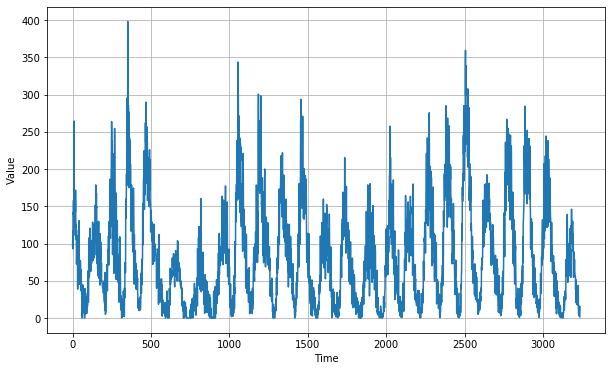

In [5]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

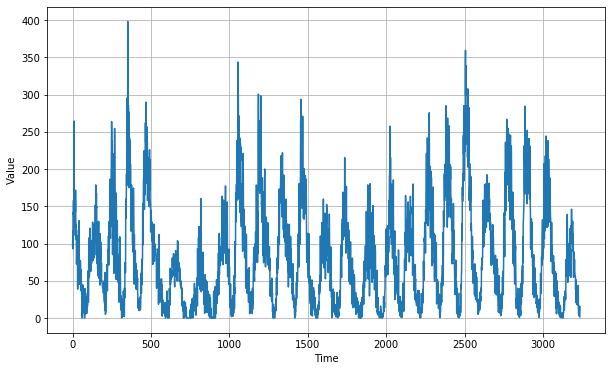

In [6]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

## Data preprocessing

In [7]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Training with dynamic learning rate

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

with tf.device('/device:GPU:0'):
    history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 6s 500ms/step - loss: 80.3072 - mae: 80.3315
Epoch 2/100
12/12 [==============================] - 1s 47ms/step - loss: 77.9405 - mae: 78.5896
Epoch 3/100
12/12 [==============================] - 1s 48ms/step - loss: 75.2415 - mae: 75.9445
Epoch 4/100
12/12 [==============================] - 1s 47ms/step - loss: 72.2421 - mae: 72.7693
Epoch 5/100
12/12 [==============================] - 1s 49ms/step - loss: 68.5303 - mae: 69.2661
Epoch 6/100
12/12 [==============================] - 1s 47ms/step - loss: 64.8655 - mae: 65.6140
Epoch 7/100
12/12 [==============================] - 0s 41ms/step - loss: 61.1551 - mae: 62.0189
Epoch 8/100
12/12 [==============================] - 0s 38ms/step - loss: 58.2311 - mae: 58.6465
Epoch 9/100
12/12 [========

12/12 [==============================] - 0s 41ms/step - loss: 20.6146 - mae: 21.1392
Epoch 59/100
12/12 [==============================] - 0s 41ms/step - loss: 20.2411 - mae: 20.7571
Epoch 60/100
12/12 [==============================] - 0s 40ms/step - loss: 19.8599 - mae: 20.3675
Epoch 61/100
12/12 [==============================] - 0s 39ms/step - loss: 19.5709 - mae: 20.0732
Epoch 62/100
12/12 [==============================] - 0s 41ms/step - loss: 19.2822 - mae: 19.7898
Epoch 63/100
12/12 [==============================] - 1s 51ms/step - loss: 20.3256 - mae: 20.7618
Epoch 64/100
12/12 [==============================] - 1s 51ms/step - loss: 22.9920 - mae: 23.8479
Epoch 65/100
12/12 [==============================] - 1s 49ms/step - loss: 21.4272 - mae: 21.8940
Epoch 66/100
12/12 [==============================] - 1s 51ms/step - loss: 20.8018 - mae: 21.3008
Epoch 67/100
12/12 [==============================] - 1s 51ms/step - loss: 19.2876 - mae: 19.7751
Epoch 68/100
12/12 [=============

## Result

[1e-08, 0.0001, 0, 60]

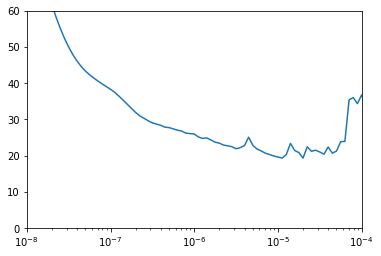

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

## Training with fixed learning rate

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

with tf.device('/device:GPU:0'):
    history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 4s 145ms/step - loss: 37.8895 - mae: 38.6059
Epoch 2/500
30/30 [==============================] - 1s 19ms/step - loss: 24.1465 - mae: 24.6112
Epoch 3/500
30/30 [==============================] - 1s 19ms/step - loss: 22.0205 - mae: 22.5112
Epoch 4/500
30/30 [==============================] - 1s 19ms/step - loss: 19.8473 - mae: 20.3490
Epoch 5/500
30/30 [==============================] - 1s 19ms/step - loss: 19.5129 - mae: 20.0170
Epoch 6/500
30/30 [==============================] - 1s 22ms/step - loss: 19.1338 - mae: 19.6244
Epoch 7/500
30/30 [==============================] - 1s 22ms/step - loss: 18.7991 - mae: 19.2972
Epoch 8/500
30/30 [==============================] - 1s 22ms/step - loss: 18.5390 - mae: 19.0127
Epoch 9/500
30/30 [==============================] - 1s 22ms/step - loss: 18.3587 - mae: 18.8708
Epoch 10/500
30/30 [==============================] - 1s 22ms/step - loss: 18.4545 - mae: 18.9693
Epoch 11/500
30/30 [========

Epoch 63/500
30/30 [==============================] - 1s 25ms/step - loss: 16.5472 - mae: 17.0265
Epoch 64/500
30/30 [==============================] - 1s 21ms/step - loss: 16.6066 - mae: 17.0912
Epoch 65/500
30/30 [==============================] - 1s 19ms/step - loss: 16.6806 - mae: 17.1575
Epoch 66/500
30/30 [==============================] - 1s 19ms/step - loss: 16.5957 - mae: 17.0941
Epoch 67/500
30/30 [==============================] - 1s 19ms/step - loss: 16.5785 - mae: 17.0658
Epoch 68/500
30/30 [==============================] - 1s 19ms/step - loss: 16.5345 - mae: 17.0155
Epoch 69/500
30/30 [==============================] - 1s 19ms/step - loss: 16.5238 - mae: 17.0163
Epoch 70/500
30/30 [==============================] - 1s 19ms/step - loss: 16.8414 - mae: 17.2932
Epoch 71/500
30/30 [==============================] - 1s 22ms/step - loss: 16.7555 - mae: 17.2621
Epoch 72/500
30/30 [==============================] - 1s 22ms/step - loss: 16.4439 - mae: 16.9315
Epoch 73/500
30/30 [

30/30 [==============================] - 1s 19ms/step - loss: 15.9609 - mae: 16.4611
Epoch 147/500
30/30 [==============================] - 1s 19ms/step - loss: 15.9355 - mae: 16.4373
Epoch 148/500
30/30 [==============================] - 1s 19ms/step - loss: 15.9020 - mae: 16.3938
Epoch 149/500
30/30 [==============================] - 1s 20ms/step - loss: 15.9491 - mae: 16.4274
Epoch 150/500
30/30 [==============================] - 1s 22ms/step - loss: 15.9719 - mae: 16.4698
Epoch 151/500
30/30 [==============================] - 1s 23ms/step - loss: 15.8492 - mae: 16.3437
Epoch 152/500
30/30 [==============================] - 1s 22ms/step - loss: 16.0506 - mae: 16.5408
Epoch 153/500
30/30 [==============================] - 1s 23ms/step - loss: 15.8931 - mae: 16.3797
Epoch 154/500
30/30 [==============================] - 1s 23ms/step - loss: 15.8901 - mae: 16.3873
Epoch 155/500
30/30 [==============================] - 1s 21ms/step - loss: 15.9054 - mae: 16.3911
Epoch 156/500
30/30 [===

30/30 [==============================] - 1s 19ms/step - loss: 15.6354 - mae: 16.1423
Epoch 229/500
30/30 [==============================] - 1s 19ms/step - loss: 15.3901 - mae: 15.8940
Epoch 230/500
30/30 [==============================] - 1s 19ms/step - loss: 15.4471 - mae: 15.9241
Epoch 231/500
30/30 [==============================] - 1s 19ms/step - loss: 15.4026 - mae: 15.8978
Epoch 232/500
30/30 [==============================] - 1s 19ms/step - loss: 15.3789 - mae: 15.8760
Epoch 233/500
30/30 [==============================] - 1s 20ms/step - loss: 15.5286 - mae: 16.0276
Epoch 234/500
30/30 [==============================] - 1s 23ms/step - loss: 15.8534 - mae: 16.3528
Epoch 235/500
30/30 [==============================] - 1s 22ms/step - loss: 15.5380 - mae: 16.0203
Epoch 236/500
30/30 [==============================] - 1s 23ms/step - loss: 15.3686 - mae: 15.8514
Epoch 237/500
30/30 [==============================] - 1s 22ms/step - loss: 15.4117 - mae: 15.8956
Epoch 238/500
30/30 [===

30/30 [==============================] - 1s 20ms/step - loss: 15.0611 - mae: 15.5571
Epoch 311/500
30/30 [==============================] - 1s 22ms/step - loss: 15.1852 - mae: 15.6736
Epoch 312/500
30/30 [==============================] - 1s 22ms/step - loss: 15.1233 - mae: 15.6069
Epoch 313/500
30/30 [==============================] - 1s 22ms/step - loss: 14.9947 - mae: 15.4658
Epoch 314/500
30/30 [==============================] - 1s 22ms/step - loss: 15.0943 - mae: 15.5847
Epoch 315/500
30/30 [==============================] - 1s 23ms/step - loss: 14.9568 - mae: 15.4439
Epoch 316/500
30/30 [==============================] - 1s 22ms/step - loss: 15.1041 - mae: 15.5739
Epoch 317/500
30/30 [==============================] - 1s 22ms/step - loss: 15.0354 - mae: 15.5422
Epoch 318/500
30/30 [==============================] - 1s 23ms/step - loss: 15.1419 - mae: 15.6546
Epoch 319/500
30/30 [==============================] - 1s 23ms/step - loss: 15.2093 - mae: 15.7089
Epoch 320/500
30/30 [===

30/30 [==============================] - 1s 22ms/step - loss: 14.5510 - mae: 15.0429
Epoch 393/500
30/30 [==============================] - 1s 19ms/step - loss: 14.6151 - mae: 15.1203
Epoch 394/500
30/30 [==============================] - 1s 20ms/step - loss: 14.7421 - mae: 15.2329
Epoch 395/500
30/30 [==============================] - 1s 21ms/step - loss: 14.5712 - mae: 15.0576
Epoch 396/500
30/30 [==============================] - 1s 21ms/step - loss: 14.6044 - mae: 15.0926
Epoch 397/500
30/30 [==============================] - 1s 21ms/step - loss: 14.7058 - mae: 15.1888
Epoch 398/500
30/30 [==============================] - 1s 21ms/step - loss: 14.6495 - mae: 15.1395
Epoch 399/500
30/30 [==============================] - 1s 21ms/step - loss: 14.6612 - mae: 15.1632
Epoch 400/500
30/30 [==============================] - 1s 22ms/step - loss: 14.5517 - mae: 15.0635
Epoch 401/500
30/30 [==============================] - 1s 21ms/step - loss: 14.8218 - mae: 15.3183
Epoch 402/500
30/30 [===

30/30 [==============================] - 1s 19ms/step - loss: 14.2179 - mae: 14.7025
Epoch 475/500
30/30 [==============================] - 1s 20ms/step - loss: 14.1687 - mae: 14.6600
Epoch 476/500
30/30 [==============================] - 1s 21ms/step - loss: 14.2302 - mae: 14.7166
Epoch 477/500
30/30 [==============================] - 1s 22ms/step - loss: 14.2482 - mae: 14.7355
Epoch 478/500
30/30 [==============================] - 1s 23ms/step - loss: 14.2978 - mae: 14.8003
Epoch 479/500
30/30 [==============================] - 1s 22ms/step - loss: 14.2005 - mae: 14.6886
Epoch 480/500
30/30 [==============================] - 1s 22ms/step - loss: 14.1963 - mae: 14.6868
Epoch 481/500
30/30 [==============================] - 1s 23ms/step - loss: 14.2687 - mae: 14.7501
Epoch 482/500
30/30 [==============================] - 1s 21ms/step - loss: 14.2422 - mae: 14.7346
Epoch 483/500
30/30 [==============================] - 1s 19ms/step - loss: 14.1654 - mae: 14.6592
Epoch 484/500
30/30 [===

## Results

In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

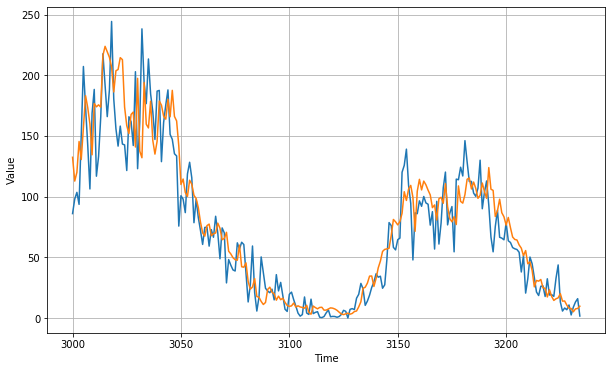

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

16.713465

<Figure size 432x288 with 0 Axes>

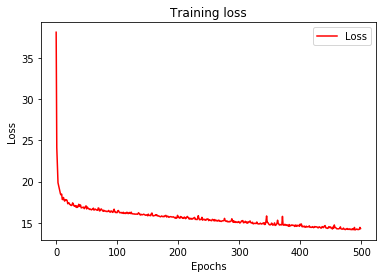

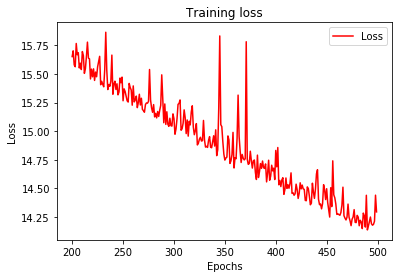

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [17]:
print(rnn_forecast)

[132.39406   112.78627   120.04337   145.41568   130.55598   157.03128
 183.12141   173.30356   159.86633   134.42693   176.71802   173.98831
 175.61153   173.70627   216.28029   223.81328   219.36989   214.78069
 206.83441   186.2329    203.68369   204.7134    214.49535   212.84723
 173.75735   158.47885   151.93634   167.68198   169.65515   140.87003
 197.43643   137.55527   132.02121   194.01651   159.63382   156.57611
 178.5815    146.41219   135.01994   145.65503   178.72993   175.31612
 166.38628   163.79926   180.16513   165.72029   187.5343    166.06955
 162.34784   141.75885   109.99956   114.48419   103.414986  100.17789
 113.49175   110.195145  101.00628    98.453026   91.031334   79.062706
  70.09896    67.39182    76.12046    77.33553    67.77344    69.45995
  69.97802    78.11617    73.95269    64.46089    65.54299    70.56998
  54.999268   52.775105   49.66294    48.025757   47.587234   60.002457
  42.20348    41.83481    45.376007   30.029684   23.759619   25.518333
  3